In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define the dataset loader
def load_data(ticker):
    ticker = yf.Ticker(ticker)
    historical_data = ticker.history(period="10y")
    close = np.array(historical_data.Close)
    open = np.array(historical_data.Open)

    next_open = open[2:]
    next_close = close[2:]
    last_open = open[:-2]
    last_close = close[:-2]
    open = open[1:-1]
    close = close[1:-1]

    vol = np.array(historical_data.Volume)[1:-1]
    vol = vol / np.mean(vol)

    obj = (next_close - next_open) / next_open
    data = np.concatenate([[(close - open) / open],
                           [(next_open - close) / close],
                           [vol]])
    return data.T.astype(np.float32), obj.astype(np.float32)

# Load data from Yahoo Finance
data, targets = load_data("NVDA")

# Prepare the rolling window inputs and corresponding targets
window_size = 20
n_stocks = 1  # Number of different stocks to predict (AAPL)
n_features = data.shape[1]  # Number of features per time step

inputs = []
for i in range(len(data) - window_size):
    inputs.append(data[i:i + window_size])

inputs = np.array(inputs)
targets = targets[window_size:]  # Adjust targets to match the input windows

# Split the dataset into training and testing sets
split_idx = int(0.8 * len(inputs))
inputs_train, inputs_test = inputs[:split_idx], inputs[split_idx:]
targets_train, targets_test = targets[:split_idx], targets[split_idx:]

# Convert to PyTorch tensors
inputs_train = torch.from_numpy(inputs_train).permute(0, 2, 1)  # Change shape to (batch_size, n_features, sequence_length)
targets_train = torch.from_numpy(targets_train).float()  # Keep the shape to match multiple stock outputs
inputs_test = torch.from_numpy(inputs_test).permute(0, 2, 1)
targets_test = torch.from_numpy(targets_test).float()

# Define the 1D convolutional model
class StockReturnPredictor(nn.Module):
    def __init__(self):
        super(StockReturnPredictor, self).__init__()
        self.stock_convs = nn.ModuleList([nn.Sequential(
            nn.Conv1d(in_channels=n_features, out_channels=8, kernel_size=3),
            nn.Tanh(),
            nn.Conv1d(in_channels=8, out_channels=4, kernel_size=3),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(4 * (window_size - 3 - 3 + 1 + 1), 1),  # Add linear layer after convolutions
        ) for _ in range(n_stocks)])
        self.fc1 = nn.Linear(1 * n_stocks, n_stocks)  # Output size matches number of stocks

    def forward(self, x):
        stock_features = []
        for i, conv in enumerate(self.stock_convs):
            stock_input = x[:, :, :]  # Use the same input for each stock
            stock_output = conv(stock_input)
            stock_features.append(stock_output)
            
        
        x = torch.cat(stock_features, dim=1)  # Concatenate features from all stocks
        x = self.fc1(x)
        return x

# Instantiate the model, define loss and optimizer
model = StockReturnPredictor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 2000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Add batch dimension (batch_size, channels, sequence_length)
    inputs_batch = inputs_train
    outputs = model(inputs_batch)
    
    loss = criterion(outputs.squeeze(), targets_train)  # Squeeze outputs to match target shape
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')

print("Training finished.")

# Evaluation on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(inputs_test).squeeze()
    test_loss = mean_squared_error(targets_test.numpy(), test_outputs.numpy())
    print(f'Test Loss (MSE): {test_loss:.4f}')


Epoch [100/2000], Loss: 0.0025
Epoch [200/2000], Loss: 0.0015
Epoch [300/2000], Loss: 0.0011
Epoch [400/2000], Loss: 0.0009
Epoch [500/2000], Loss: 0.0008
Epoch [600/2000], Loss: 0.0008
Epoch [700/2000], Loss: 0.0007
Epoch [800/2000], Loss: 0.0007
Epoch [900/2000], Loss: 0.0007
Epoch [1000/2000], Loss: 0.0007
Epoch [1100/2000], Loss: 0.0007
Epoch [1200/2000], Loss: 0.0006
Epoch [1300/2000], Loss: 0.0006
Epoch [1400/2000], Loss: 0.0006
Epoch [1500/2000], Loss: 0.0006
Epoch [1600/2000], Loss: 0.0006
Epoch [1700/2000], Loss: 0.0006
Epoch [1800/2000], Loss: 0.0006
Epoch [1900/2000], Loss: 0.0006
Epoch [2000/2000], Loss: 0.0006
Training finished.
Test Loss (MSE): 0.0006


0.005631403532955298 0.0017233792135220112


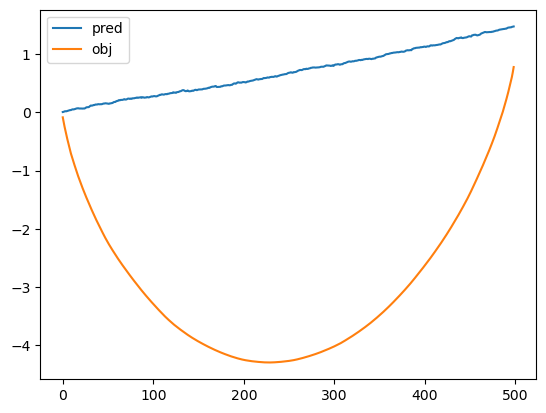

In [25]:

pred = test_outputs
obj = targets_test.detach().cpu().numpy().T



exp = np.sqrt(np.dot(pred, pred) / len(pred))
real = (np.dot(pred, obj) / len(pred)) / exp

print(exp, real)

obj_sort = np.argsort(obj)
plt.plot(np.cumsum(pred[obj_sort]), label="pred")
plt.plot(np.cumsum(obj[obj_sort]), label="obj")

plt.legend()